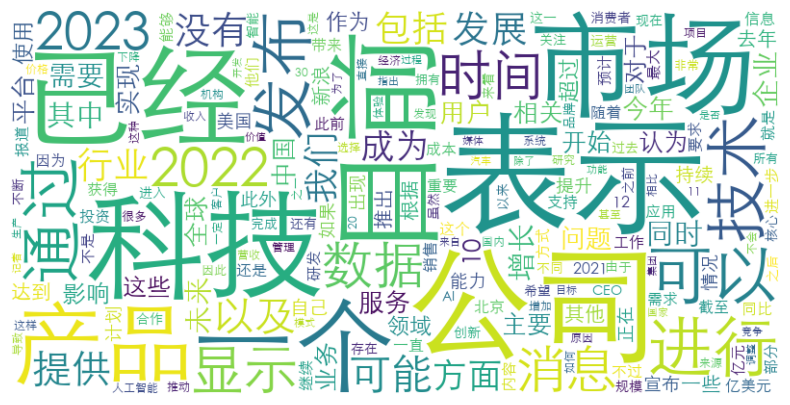

In [5]:
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 读取JSON文件，并指定编码为UTF-8
with open('D:\Program\Python\inverted_index.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 将关键词和对应新闻ID转换为词频字典
word_freq = {}
for keyword, news_ids in data.items():
    if len(keyword) > 1:
        word_freq[keyword] = len(news_ids)

# 创建词云对象并生成词云，设置字体为对应的中文字体（根据自己的实际字体文件路径进行修改）
font_path = r'C:\Windows\Fonts\STXIHEI.TTF'  # 修改为正确的字体文件路径
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path)
wordcloud.generate_from_frequencies(word_freq)

# 绘制词云图像
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



<font size=5>通过图表可看出，新闻内容与时间息息相关，出现了“目前”、“已经”、“时间”、“2022”、“2023”等词汇，而且最为明显</font>  
<font size=5>其次是“公司”、“市场”、“产品”、“科技”，说明科技发展与科技公司、市场需求息息相关</font>  
<font size=5>还有一些表示“数据”、“人工智能”的词汇，这表明AI、大数据近年来备受关注，字小的原因并不一定是它不够突出，而是其他一些词汇为常用词</font>  

In [ ]:
import os
import django
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "pro.settings")
django.setup()
from news.models import News
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, date2num
from datetime import datetime, timedelta

# 获取新闻对象列表
news = News.objects.all()

# 统计每个时间间隔内的新闻数量
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 8, 31)
interval = timedelta(days=15)
dates = []
counts = []

while start_date <= end_date:
    count = news.filter(date__gte=start_date, date__lt=start_date + interval).count()
    dates.append(start_date)
    counts.append(count)
    start_date += interval

# 将日期转换为matplotlib可识别的格式
x = date2num(dates)

# 创建条形图
plt.figure(figsize=(10, 6))
plt.bar(x, counts, align='center', width=3)

# 设置x轴刻度标签
date_formatter = DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_formatter)

# 设置x轴刻度密度，防止标签重叠
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

# 在每个条的顶部显示数量
for i in range(len(x)):
    plt.text(x[i], counts[i], str(counts[i]), ha='center', va='bottom')

# 设置标题和坐标轴标签
plt.title('News Count by Date')
plt.xlabel('Date')
plt.ylabel('News Count')

# 旋转x轴刻度标签，使其更易读
plt.xticks(rotation=45)

# 显示图形
plt.tight_layout()
plt.show()





![程序运行图片](Figure_1.png)  
<font size=5>图是以2023年1月1日为起始，2023年8月31日为终止</font>  
<font size=5>可以看出2月初与5月中旬科技板块发文量巨大，一个对应chatGPT的爆火，另一个对应的是其他语言大模型的紧追</font>  
<font size=5>其余月份发文量较为平均，4月稍显颓势</font>  

In [ ]:
import jieba
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
import os
import django
import numpy as np

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "pro.settings")
django.setup()
from news.models import News

# 获取新闻对象列表
news = News.objects.all()

# 获取新闻内容列表
news_content = [n.content for n in news]

# 使用jieba进行分词
segmented_news_content = []
for content in tqdm(news_content, desc="Segmenting"):
    segmented_words = jieba.lcut(content)
    segmented_news_content.append(segmented_words)

# 过滤分词结果，保留长度大于1的词语
filtered_segmented_news_content = []
for segmented_words_list in tqdm(segmented_news_content, desc="Filtering"):
    filtered_segmented_words = []
    for word in segmented_words_list:
        if len(word) > 1:
            filtered_segmented_words.append(word)
    filtered_segmented_news_content.append(' '.join(filtered_segmented_words))

# 使用TfidfVectorizer获取tf-idf特征
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(filtered_segmented_news_content)

# 使用K-means对数据进行聚类
kmeans = KMeans(n_clusters=10)  # 将数据聚成10个类别
clusters = kmeans.fit_predict(tfidf_features)

# 使用t-SNE将高维特征降维至三维
tsne = TSNE(n_components=3)
X_embedded = tsne.fit_transform(tfidf_features.toarray())

# 将聚类结果和t-SNE降维后的特征矩阵合并
merged_features = np.column_stack((X_embedded, clusters))

# 统计每个类别的数量
cluster_counts = Counter(clusters)

# 设置颜色列表，确保有足够多的不同颜色
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'purple', 'orange', 'gray', 'brown', 'olive', 'pink', 'teal']

# 绘制三维散点图，并根据聚类结果进行着色
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(len(clusters)):
    ax.scatter(merged_features[i, 0], merged_features[i, 1], merged_features[i, 2], c=colors[clusters[i]])

max_count = max(cluster_counts.values())
bbox_props = dict(boxstyle="round", fc="w", ec="gray", lw=2)  # bbox的样式参数
text_x = 75  # 注释框的x轴位置
text_y = 0  # 注释框的y轴位置
text_z = 0  # 注释框的z轴位置
text_spacing = 60  # 调整注释框之间的间距
for cluster, count in cluster_counts.items():
    text_z += text_spacing
    ax.text(text_x, text_y, text_z, f'Cluster {cluster}: {count}', bbox=bbox_props, color=colors[cluster])

plt.show()


![程序运行图片](Figure_3.png)  
<font size=4>程序将所有新闻内容进行分词处理，根据tf-idf提取特征，再用K-means对数据分成10个聚类，最后用t-SNE降维为3维散点图</font>  
<font size=4>可以看出所有点集中分布类似一个椭球，只有少量Cluster 9点散布在外面，且Cluster 9大部分点都在椭球外侧，点数也比较多，可以认为分类比较笼统，可以更细化</font>  
<font size=4>其余分类如Cluster 1、Cluster 4、 Cluster 5、 Cluster 6分布比较集中，可以认为这些新闻关联性较强</font>  
<font size=4>同时也能发现，聚类数目越小，分类效果越好</font>  